# Stochastic Kronecker Graphical Models - A Finite Mixture Model


We propose the mixture model below for stochastic kronecker graph solutions

<img src="mix_model.png" style="width: 30%" align="right">

- Notation Glossary:  
    - $K$ : Number of kronecker layers or products to obtain $\Phi$
    - $N$ : Number of rows (=columns)
    - $\gamma_\alpha$, $\gamma_\beta$
    - $\alpha_k$, $\beta_k$
    - $\mu_k$
    - $\theta_{ij}$
    - $\Sigma$
    - $\epsilon$
    - $n_{ij}$
    - $Z$
    - $U$
    - $\Phi$
    - $G$

##### Further thoughts and ideas
1. The noise addition could be to the kronecker result, not to each theta. This would mean that whatever the type of $\Phi$ we learn or use, we cannot be more certain than the variance of the noise we add to the kronecker product. This will stop islands from occuring. (How do we write that in a graphical representation?)

2. Should we be learning a transition matrix for $\theta_{ij}$ elements? There ought to be some model over the structure of $\theta^{(k)}_c$. However, a transition is a valid model for only sequences, this is not a sequence...

In the following, we will implement our mixture model and generate examples from it.

In [1]:
# All imports
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Methods being used:

In [2]:
def kronecker_product(mat1, mat2):
    m1 = tf.shape(mat1)[0]
    n1 = tf.size(mat1) // m1
    m2 = tf.shape(mat2)[0]
    n2 = tf.size(mat2) // m2
    mat2_rsh =tf.reshape(mat1, [1, m1, 1, n1])
    mat1_rsh =tf.reshape(mat2, [m2, 1, n2, 1])
    return tf.reshape(mat1_rsh*mat2_rsh, [m1 * m2, n1 * n2])

In [3]:
def addNoise2Mat(mat, mean=0, std=0.01, NRMLZ=True):
    # Set the seed so the results are reproducible.
    np.random.seed(123)
    # Make distribution, sample and add
    p_eta = tfd.Normal(loc=mean, scale=std, name='AdditiveEdgeNoise')
    eta_c = p_eta.sample(tf.shape(mat))
    mat_noise = mat + eta_c
    # Make sure values do not run off
    # Clip values out of [0,1]
    if NRMLZ:
        mat_noise_nrml   = tf.maximum(tf.minimum(mat_noise,1),0)
        return mat_noise_nrml
    else:
        return mat_noise

### Parameters:

In [4]:
theta_shape_   = np.array([3,3])
# alpha_         = [1.0]
# beta_          = [1.0]
K_             = 5
NoiseScale_    = 0.1

# Run Parameters
NumSamples    = 5

### Mixture Model implementation:

Our mixture model still uses the layered network structure proposed in the work of Stochastic Kronecker Graphs. It relaxes the assumption that the $\theta$ at every kronecker layer is the same. Which means the following:

* $G$ is the adjacency matrix of a large network whose size is $\scriptsize N^K \times N^K$
* $G \sim \Phi$ which is a set of independent binomial distributions on the occurrence of edges
* We assume a set of $\theta_k$ make up the $\Phi$ through successive kronecker products
    
    $\Phi   = \theta^{(1)}\otimes \theta^{(2)} \otimes \dots \theta^{(k)} \dots \otimes \theta^{(K)}$
* If we assume the sizes of each of these $\theta^{(k)}$ are fixed to $N\times N$, then $\Phi_{N^K\times N^k}$
* Further according to our mixture model we allow each $\theta^{(k)}$ to be of a particular "basis" or "class". That is  $\theta^{(k)} \in [\theta_1, \theta_2, \dots, \theta_c, \dots, \theta_C]_{C\rightarrow\infty}$ because we want to model that $\theta^{(k)}$ is drawn from a continuous distribution as shown in our mixture model.
    
    For example $\theta^{(2)}_4$ is a basis $\theta$ belonging to a class with label 4 and has the index 2 in the sequence of kronecker multiplications to obtain $\Phi$


In the following sections we implement the above mixture model in pieces.

We propose two log-normal distributions which generate $\alpha_k$ and $\beta_k$ values for every $k \in K$

In [5]:
# Should come from another source which computes how many kronecker products are needed
# K   = tf.placeholder(tf.int32) # Incorrect because cant unfurl as a graph on the fly

In [6]:
# Sample from separate log-normal distributions to get K number of values for alpha and beta
# Setup parameters
sig_a = tf.placeholder_with_default([1.0], [1]) # skew parameter TUNE
sig_b = tf.placeholder_with_default([1.0], [1]) # skew parameter TUNE
mean_a  = tf.placeholder_with_default([0.0], [1]) # mean parameter TUNE
mean_b  = tf.placeholder_with_default([0.0], [1]) # mean parameter TUNE
# Make log-normal distributions
# alpha_batch_shape = beta_batch_shape    = K
gamma_a   = tfd.LogNormal(loc=mean_a, scale=sig_a, name="LogNormal-Alphas")
gamma_b   = tfd.LogNormal(loc=mean_b, scale=sig_b, name="LogNormal-Betas")
# Sample from these distributions
alpha_batch   = gamma_a.sample(K_)
beta_batch    = gamma_b.sample(K_)

We build a batch of $K$ Beta distributions

In [7]:
# Build K number of Beta distributions from alpha and beta values
mu_batch   = tfd.Beta(alpha_batch, beta_batch, name='kBetaDistb')

Each of the $K$ Beta distributions produce the $N\times N$ number of $\theta_{ij}$ elements for their corresponding $\theta^{(k)}_c$

In [8]:
# Get theta_ij values for every theta_k from the corresponding mu_k
theta_k_shape   = tf.placeholder(tf.int32, (2,))
theta_c_set     = tf.squeeze(mu_batch.sample(sample_shape=theta_k_shape, name="theta_set"), axis=-1)

In [9]:
# Sample from mu_k for theta_ij values

# alpha  = tf.placeholder_with_default([1.0], [1])
# beta   = tf.placeholder_with_default([1.0], [1])
# mu_batch_shape   = tf.placeholder(tf.int32)
# p_mu   = tfd.Beta(alpha, beta, name='Mu_distb')
# mu_batch  = tf.squeeze(p_mu.sample(mu_batch_shape),axis=2)
# theta_c   = mu_batch

In [10]:
# Use the mu samples as thresholds for 
# theta Bernoulli distributions of edges

# theta_c_distb = tfd.Bernoulli(probs=mu_batch, name='theta_c') # Actually never used

Kronecker multiply to obtain the threshold values for $\Phi$

In [11]:
NoiseScale   = tf.placeholder_with_default(0.01,[])   
phi_batch    = addNoise2Mat(theta_c_set[...,0])
for k in range(1,K_):
    # Add noise to the theta
#     print(k)
    ktheta_c   =  addNoise2Mat(theta_c_set[...,k], std=NoiseScale)
    # Do kronecker product
    phi_batch   = kronecker_product(phi_batch, ktheta_c)

Sample from the $\Phi$

In [12]:
# Pk_c_distb   = tfd.Bernoulli(probs=Pk_c, name='Pk_c')
# G_c          = Pk_c_distb.sample(NumSamples)

Phi   = tfd.Bernoulli(probs=phi_batch, name='Phi')
G_c   = Phi.sample(NumSamples)


### Run and Plot:

In [13]:
sess = tf.Session()
# [G, Pk_c_s, theta_c,
# alphas, betas, theta_c_set] = sess.run([G_c, Phi, mu_batch, alpha_batch, beta_batch, theta_c_set], 
#                                 feed_dict={K:K_,
#                                            mu_batch_shape:theta_shape_,
#                                            theta_k_shape:theta_shape_,
#                                            alpha:alpha_,
#                                            beta:beta_,
#                                           })

[G_c_] = sess.run([G_c],
             feed_dict={
                 NoiseScale:NoiseScale_,
                 theta_k_shape:theta_shape_,
             })



In [14]:
print(G_c_)
# print(theta_c)
# print(theta_c_set)
# print(np.shape(theta_c_set))
# print(Pk_c_s.shape)
# print(G.shape)
# print(alphas)
# print(betas)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 1]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 0 1]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 1]
  [0 0 0 ... 0 1 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 1]
  [0 0 0 ... 0 0 0]]]


NameError: name 'theta_c' is not defined

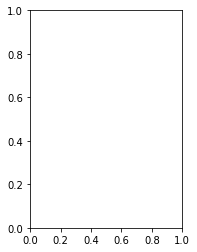

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(theta_c)
plt.title('theta_c')

plt.subplot(1,2,2)
plt.imshow(Pk_c_s)
plt.title('P_k_c')

In [ ]:
plt.figure()
plt.title('All samples')
r = np.floor(np.sqrt(NumSamples))
c = np.ceil(float(NumSamples)/r)
for i in range(0,NumSamples):
    plt.subplot(r,c,i+1)
    plt.spy(G[i,:], markersize=0.1)